# Final project for Sta 671
### Prediction of the price for rooms

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder  

import xgboost as xgb
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

## 1. loading data & EDA

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,host_is_superhost,bathrooms,bedrooms,beds,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,t,1.0,0,1,Real Bed,2092,1,0,365,t,f,strict_14_with_grace_period,f,f,2
1,6274,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,t,1.0,1,1,Real Bed,558,1,0,15,f,f,moderate,f,f,1
2,6025,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,f,1.0,0,1,Real Bed,1052,3,351,90,t,f,moderate,f,f,3
3,8931,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,f,1.0,1,3,Real Bed,0,4,0,1125,t,f,flexible,f,f,2
4,7524,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,t,1.0,1,3,Real Bed,2092,1,0,365,t,f,moderate,f,f,3


In [5]:
train.columns

Index(['id', 'neighbourhood', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'host_since',
       'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'price'],
      dtype='object')

In [6]:
# delete uninformative features and seperate label
y_train = train.price
# y_train = y_train.astype('object')
X_train = train.drop(['id','last_review','host_since','price'],axis=1).copy()
le = LabelEncoder()

X_test = test.drop(['id','last_review','host_since'],axis=1).copy()

X_train.head()

,neighbourhood,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,host_is_superhost,bathrooms,bedrooms,beds,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Palermo,Entire home/apt,1,170,2.48,4,346,t,1.0,0,1,Real Bed,2092,1,0,365,t,f,strict_14_with_grace_period,f,f
1,Colegiales,Private room,1,11,0.57,1,0,t,1.0,1,1,Real Bed,558,1,0,15,f,f,moderate,f,f
2,Recoleta,Entire home/apt,3,2,0.08,19,360,f,1.0,0,1,Real Bed,1052,3,351,90,t,f,moderate,f,f
3,Recoleta,Entire home/apt,2,1,0.13,1,267,f,1.0,1,3,Real Bed,0,4,0,1125,t,f,flexible,f,f
4,San Nicolás,Entire home/apt,2,31,1.54,5,365,t,1.0,1,3,Real Bed,2092,1,0,365,t,f,moderate,f,f


In [7]:
X_train.dtypes

neighbourhood                        object
room_type                            object
minimum_nights                        int64
number_of_reviews                     int64
reviews_per_month                   float64
calculated_host_listings_count        int64
availability_365                      int64
host_is_superhost                    object
bathrooms                           float64
bedrooms                              int64
beds                                  int64
bed_type                             object
cleaning_fee                          int64
guests_included                       int64
extra_people                          int64
maximum_nights                        int64
instant_bookable                     object
is_business_travel_ready             object
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
dtype: object

In [8]:
factor_feature = X_train.columns[X_train.dtypes==object]
factor_feature

Index(['neighbourhood', 'room_type', 'host_is_superhost', 'bed_type',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')

In [9]:
for factor in factor_feature:
    print('{} variables:{}'.format(factor, X_train[factor].unique()))

neighbourhood variables:['Palermo' 'Colegiales' 'Recoleta' 'San Nicolás' 'Caballito' 'Núñez'
 'Balvanera' 'Constitución' 'Monserrat' 'Retiro' 'San Telmo' 'Belgrano'
 'Villa Devoto' 'Puerto Madero' 'Almagro' 'Villa Santa Rita'
 'Villa Crespo' 'Villa Urquiza' 'Parque Patricios' 'Coghlan' 'Flores'
 'Barracas' 'Agronomía' 'Chacarita' 'Villa Ortúzar' 'Villa del Parque'
 'Saavedra' 'Villa Pueyrredón' 'Parque Chacabuco' 'Parque Chas' 'Boedo'
 'Monte Castro' 'Floresta' 'La Paternal' 'La Boca' 'San Cristóbal'
 'Villa Luro' 'Liniers' 'Mataderos' 'Villa General Mitre'
 'Parque Avellaneda' 'Nueva Pompeya' 'Versalles' 'Vélez Sársfield'
 'Villa Real']
room_type variables:['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']
host_is_superhost variables:['t' 'f']
bed_type variables:['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']
instant_bookable variables:['t' 'f']
is_business_travel_ready variables:['f']
cancellation_policy variables:['strict_14_with_grace_period' 'moderate' 'flexible' 

In [10]:
quant_feature = X_train.columns[X_train.dtypes!=object]
quant_feature

Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'bathrooms',
       'bedrooms', 'beds', 'cleaning_fee', 'guests_included', 'extra_people',
       'maximum_nights'],
      dtype='object')

In [38]:
X_train[quant_feature]

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,bathrooms,bedrooms,beds,cleaning_fee,guests_included,extra_people,maximum_nights
0,1,170,2.48,4,346,1.0,0,1,2092,1,0,365
1,1,11,0.57,1,0,1.0,1,1,558,1,0,15
2,3,2,0.08,19,360,1.0,0,1,1052,3,351,90
3,2,1,0.13,1,267,1.0,1,3,0,4,0,1125
4,2,31,1.54,5,365,1.0,1,3,2092,1,0,365
...,...,...,...,...,...,...,...,...,...,...,...,...
9676,7,7,0.89,2,328,1.5,1,1,700,1,0,185
9677,1,5,0.43,1,0,2.0,2,5,1500,6,500,30
9678,3,1,0.30,28,174,1.0,0,2,3492,1,0,180
9679,2,28,0.58,1,0,2.0,3,3,900,1,0,1125


In [39]:
# normalize quant_feature
X_train[quant_feature] = (X_train[quant_feature]-X_train[quant_feature].mean())/X_train[quant_feature].std()

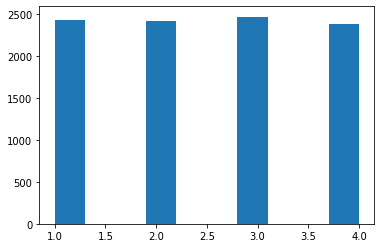

In [19]:
plt.hist(y_train.values);
# have similar amount for each class

room_type
Entire home/apt    AxesSubplot(0.125,0.125;0.775x0.755)
Hotel room         AxesSubplot(0.125,0.125;0.775x0.755)
Private room       AxesSubplot(0.125,0.125;0.775x0.755)
Shared room        AxesSubplot(0.125,0.125;0.775x0.755)
Name: price, dtype: object

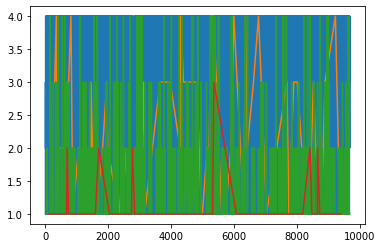

In [29]:
# feature to y relation
train.groupby('room_type')['price'].plot()

In [30]:
train.room_type.value_counts()

Entire home/apt    8366
Private room       1183
Shared room          67
Hotel room           65
Name: room_type, dtype: int64

## 2. create the first model/benchmark with Multiclass logistic regression

### i all feature and dummy and normalization with MLR

In [51]:
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.3)

X1 = pd.get_dummies(X1)
X2 = pd.get_dummies(X2)

missing_cols = set( X1.columns ) - set( X2.columns )
for c in missing_cols:
    X2[c] = 0
X2 = X2[X1.columns]

In [68]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X1, y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
clf.score(X1, y1)

0.509887839433294

In [70]:
clf.score(X2, y2)

0.4729776247848537

### ii quant feature with normalization with MLR

In [46]:
X1, X2, y1, y2 = train_test_split(X_train[quant_feature], y_train, test_size=0.3)
clf = LogisticRegression(max_iter=1000)
clf.fit(X1, y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
clf.score(X1, y1), clf.score(X2, y2)

(0.4693034238488784, 0.4664371772805508)

### ii factor feature with normalization with MLR

In [48]:
X1, X2, y1, y2 = train_test_split(X_train[factor_feature], y_train, test_size=0.3)

X1 = pd.get_dummies(X1)
X2 = pd.get_dummies(X2)

missing_cols = set( X1.columns ) - set( X2.columns )
for c in missing_cols:
    X2[c] = 0
X2 = X2[X1.columns]

clf = LogisticRegression(max_iter=1000)
clf.fit(X1, y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
clf.score(X1, y1), clf.score(X2, y2)

(0.4141086186540732, 0.3855421686746988)

## XGboost

### 1. dataset of all with dummies

In [62]:
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.3)

X1 = pd.get_dummies(X1)
X2 = pd.get_dummies(X2)

missing_cols = set( X1.columns ) - set( X2.columns )
for c in missing_cols:
    X2[c] = 0
X2 = X2[X1.columns]

In [44]:
clf = XGBClassifier(n_estimators=100, n_jobs=-1, learning_rate=0.1)

In [45]:
clf.fit(X1, y1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
print('train/test accuracy:{}/{}'.format(sum(clf.predict(X1)==y1)/len(y1), sum(clf.predict(X2)==y2)/len(y2)))

train/test accuracy:0.7460153482880756/0.49845094664371775


### 1. dataset of quants

In [47]:
X1, X2, y1, y2 = train_test_split(X_train[quant_feature], y_train, test_size=0.3)

In [63]:
clf = XGBClassifier(n_estimators=500, max_depth=10, learning_rate = 0.01, gamma =0.1, reg_alpha=1)
clf.fit(X1, y1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
print('train/test accuracy:{}/{}'.format(sum(clf.predict(X1)==y1)/len(y1), sum(clf.predict(X2)==y2)/len(y2)))

train/test accuracy:0.8938902007083825/0.5046471600688468


### tuning parameters

In [50]:
n_est = 200
max_d = [3, 5, 8, 10]
lr = [0.1, 0.01, 0.001]
ga = [10, 5, 1, 0.5, 0.1]
alpha=[10, 1, 0.1]

In [51]:
for md in max_d:
    for l in lr:
        for gamma in ga:
            for c in alpha:
                clf = XGBClassifier(n_estimators=n_est, max_depth=md, learning_rate = l, gamma =gamma, reg_alpha=c)
                clf.fit(X1, y1)
                print('max_d:{} lr:{} ga:{} alpha:{}'.format(md,l,gamma,c))
                print('train/test accuracy:{}/{}'.format(sum(clf.predict(X1)==y1)/len(y1), sum(clf.predict(X2)==y2)/len(y2)))

max_d:3 lr:0.1 ga:10 alpha:10
train/test accuracy:0.42340613931523025/0.43580034423407915
max_d:3 lr:0.1 ga:10 alpha:1
train/test accuracy:0.432556080283353/0.444750430292599
max_d:3 lr:0.1 ga:10 alpha:0.1
train/test accuracy:0.4332939787485242/0.44440619621342514
max_d:3 lr:0.1 ga:5 alpha:10
train/test accuracy:0.4445100354191263/0.4499139414802065
max_d:3 lr:0.1 ga:5 alpha:1
train/test accuracy:0.46266233766233766/0.4585197934595525
max_d:3 lr:0.1 ga:5 alpha:0.1
train/test accuracy:0.46605667060212513/0.45714285714285713
max_d:3 lr:0.1 ga:1 alpha:10
train/test accuracy:0.48760330578512395/0.4667814113597246
max_d:3 lr:0.1 ga:1 alpha:1
train/test accuracy:0.5497343565525383/0.48881239242685026
max_d:3 lr:0.1 ga:1 alpha:0.1
train/test accuracy:0.5422077922077922/0.4784853700516351
max_d:3 lr:0.1 ga:0.5 alpha:10
train/test accuracy:0.5091499409681228/0.480895008605852
max_d:3 lr:0.1 ga:0.5 alpha:1
train/test accuracy:0.5610979929161747/0.48846815834767643
max_d:3 lr:0.1 ga:0.5 alpha:0.1

max_d:8 lr:0.1 ga:10 alpha:0.1
train/test accuracy:0.44687131050767415/0.4523235800344234
max_d:8 lr:0.1 ga:5 alpha:10
train/test accuracy:0.45011806375442737/0.4585197934595525
max_d:8 lr:0.1 ga:5 alpha:1
train/test accuracy:0.5119539551357734/0.4784853700516351
max_d:8 lr:0.1 ga:5 alpha:0.1
train/test accuracy:0.5323199527744983/0.4771084337349398
max_d:8 lr:0.1 ga:1 alpha:10
train/test accuracy:0.5546044864226682/0.48709122203098104
max_d:8 lr:0.1 ga:1 alpha:1
train/test accuracy:0.8472550177095631/0.48158347676419966
max_d:8 lr:0.1 ga:1 alpha:0.1
train/test accuracy:0.8698347107438017/0.4853700516351119
max_d:8 lr:0.1 ga:0.5 alpha:10
train/test accuracy:0.6375442739079102/0.4864027538726334
max_d:8 lr:0.1 ga:0.5 alpha:1
train/test accuracy:0.9324085005903188/0.48261617900172116
max_d:8 lr:0.1 ga:0.5 alpha:0.1
train/test accuracy:0.9489374262101535/0.4750430292598967
max_d:8 lr:0.1 ga:0.1 alpha:10
train/test accuracy:0.680047225501771/0.48502581755593804
max_d:8 lr:0.1 ga:0.1 alpha:

### seems to be better than MLR and ordinal MLR.

## 3. random forest
### 1. with all

In [52]:
X_train = X_train.apply(lambda x: pd.factorize(x)[0])

In [53]:
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.3)

# X1 = pd.get_dummies(X1)
# X2 = pd.get_dummies(X2)

# missing_cols = set( X1.columns ) - set( X2.columns )
# for c in missing_cols:
#     X2[c] = 0
# X2 = X2[X1.columns]

In [54]:
clf = RandomForestClassifier(oob_score=True)
clf.fit(X1, y1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
print('train/test accuracy:{}/{}'.format(sum(clf.predict(X1)==y1)/len(y1), sum(clf.predict(X2)==y2)/len(y2)))

train/test accuracy:1.0/0.5180722891566265


In [56]:
X1.shape

(6776, 21)

In [57]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print('{} {}: {}'.format(f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1 reviews_per_month: 0.10477591517897825
2 cleaning_fee: 0.10106453658126388
3 availability_365: 0.09237273878242115
4 number_of_reviews: 0.09081809386430405
5 neighbourhood: 0.07341361404284392
6 minimum_nights: 0.0643196456879284
7 maximum_nights: 0.06108423118181588
8 calculated_host_listings_count: 0.058678864888076956
9 bedrooms: 0.05665779412226367
10 room_type: 0.05652563637089382
11 extra_people: 0.046887728726114436
12 beds: 0.042472890734576586
13 bathrooms: 0.038502822665096116
14 cancellation_policy: 0.036044870584736675
15 guests_included: 0.027651184005140644
16 instant_bookable: 0.022048235111112337
17 host_is_superhost: 0.01944372351346128
18 require_guest_profile_picture: 0.0032250030963301
19 require_guest_phone_verification: 0.0029066831663963955
20 bed_type: 0.001105787696245523
21 is_business_travel_ready: 0.0


### 2. take feature with variance > 0.05

In [58]:
selected = [indices[f] for f in range(X_train.shape[1]) if importances[indices[f]]>=0.05]

In [59]:
X_train_selected = X_train.iloc[:,selected].copy()

In [60]:
X1, X2, y1, y2 = train_test_split(X_train_selected, y_train, test_size=0.3)

In [61]:
md = [5, 10, 15, 20, 25]
for max_depth in md:
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(X1, y1)
    print('train/test accuracy:{}/{}'.format(sum(clf.predict(X1)==y1)/len(y1), sum(clf.predict(X2)==y2)/len(y2)))

train/test accuracy:0.48037190082644626/0.4929432013769363
train/test accuracy:0.6868358913813459/0.5080895008605852
train/test accuracy:0.952922077922078/0.5118760757314974
train/test accuracy:0.9995572609208973/0.5049913941480206
train/test accuracy:0.9998524203069658/0.5012048192771085
